In [1]:
import earthnet_minicuber
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import folium
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])

In [2]:
specs = {
    "lon_lat": (41.24493301281836, 0.5917756199210684), # center pixel
    "xy_shape": (512, 512), # width, height of cutout around center pixel
    "resolution": 30, # in meters.. will use this together with grid of primary provider..
    "time_interval": "2021-01-01/2021-02-01",
    "primary_provider": {
    "name": "s2",
    "kwargs": {"bands": ["B02", "B03", "B04"], "best_orbit_filter": True, "brdf_correction": True, "cloud_mask": True}
    },
    "other_providers": [
        {
            "name": "s1",
            "kwargs": {"bands": ["vv", "vh","mask"], "speckle_filter": True, "speckle_filter_kwargs": {"type": "lee", "size": 9}} 
        },
        {
            "name": "ndviclim",
            "kwargs": {"bands": ["mean", "std"]}
        }
        ]
}

In [3]:
cube = earthnet_minicuber.Minicuber.load_minicube(specs)

*** Earth Engine *** Python client initialized
/Net/Groups/BGI/people/vbenson/miniconda3/envs/dea/lib/python3.9/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/Net/Groups/BGI/people/vbenson/miniconda3/envs/dea/lib/python3.9/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))
/Net/Groups/BGI/people/vbenson/EarthNet/earthnet-minicuber/earthnet_minicuber/provider/s2/utils.py:195: RuntimeWarning: Mean of empty slice
  bands_dict[band]["Zenith"] = np.nanmean(
/Net/Groups/BGI/people/vbenson/EarthNet/earthnet-minicuber/earthnet_minicuber/provider/s2/utils.py:198: Run

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

/Net/Groups/BGI/people/vbenson/miniconda3/envs/dea/lib/python3.9/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/Net/Groups/BGI/people/vbenson/miniconda3/envs/dea/lib/python3.9/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))
/Net/Groups/BGI/people/vbenson/EarthNet/earthnet-minicuber/earthnet_minicuber/provider/sentinel1.py:90: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  valid = xr.ufuncs.isfinite(stack)
/Net/Groups/BGI/people/vbenson/miniconda3/envs/dea/lib/python3.9/site-packages/xarray/core/dataset.py:5722: FutureWar

In [4]:
cube

<xarray.Dataset>
Dimensions:        (time: 12, lat: 512, lon: 512, time_clim: 12)
Coordinates:
  * time           (time) datetime64[ns] 2021-01-05T07:49:44 ... 2021-02-01T0...
  * lon            (lon) float64 41.18 41.18 41.18 41.18 ... 41.31 41.31 41.31
  * lat            (lat) float64 0.6612 0.661 0.6607 ... 0.5229 0.5226 0.5223
  * time_clim      (time_clim) datetime64[ns] 1970-01-15 ... 1970-12-15
Data variables:
    s2_mask        (time, lat, lon) float64 dask.array<chunksize=(3, 512, 512), meta=np.ndarray>
    s2_B02         (time, lat, lon) float32 dask.array<chunksize=(3, 512, 512), meta=np.ndarray>
    s2_B03         (time, lat, lon) float32 dask.array<chunksize=(3, 512, 512), meta=np.ndarray>
    s2_B04         (time, lat, lon) float32 dask.array<chunksize=(3, 512, 512), meta=np.ndarray>
    s1_mask        (time, lat, lon) float32 dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    s1_vv          (time, lat, lon) float32 dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    s1_vh          (time, lat, lon) float32 dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    ndviclim_mean  (time_clim, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ndviclim_std   (time_clim, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

In [5]:
def map(minicube):
    x_min, x_max, y_min, y_max = minicube.lon[0].values, minicube.lon[-1].values, minicube.lat[-1].values, minicube.lat[0].values
    # Create map
    interactive_map = folium.Map(
        location=((y_min+y_max)/2, (x_min+x_max)/2),
        zoom_start=min(int((np.log(360 / (x_max-x_min)) / np.log(2))), int((np.log(360 / (y_max-y_min)) / np.log(2)))),
        tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google",
    )

    # Create bounding box coordinates to overlay on map
    line_segments = [
        (y_min, x_min),
        (y_min, x_max),
        (y_max, x_max),
        (y_max, x_min),
        (y_min, x_min),
    ]

    # Add bounding box as an overlay
    interactive_map.add_child(
        folium.features.PolyLine(locations=line_segments, color="red", opacity=0.8)
    )
    #folium.PolyLine(locations=line_segments, color="red", opacity=0.8).add_to(interactive_map)


    # Add clickable lat-lon popup box
    interactive_map.add_child(folium.features.LatLngPopup())
    return interactive_map

In [6]:
map(cube)

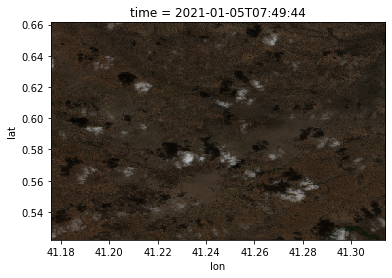

In [7]:
(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = 0)).plot.imshow(rgb="band")

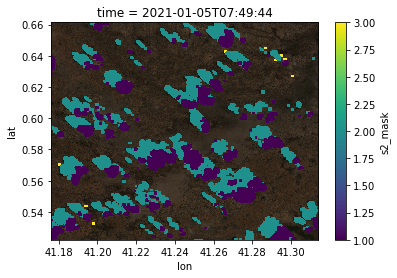

In [8]:
(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = 0)).plot.imshow(rgb="band")
cube["s2_mask"].isel(time=0).where(lambda x: x>0).plot.imshow(ax = plt.gca())

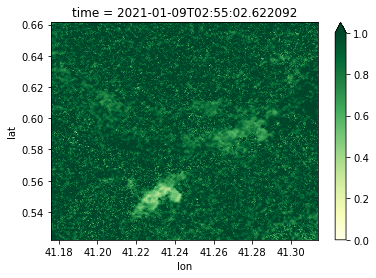

In [9]:
(4 * cube.s1_vh / (cube.s1_vh + cube.s1_vv)).isel(time=2).plot.imshow(vmin = 0, vmax = 1,cmap = cmap_veg)

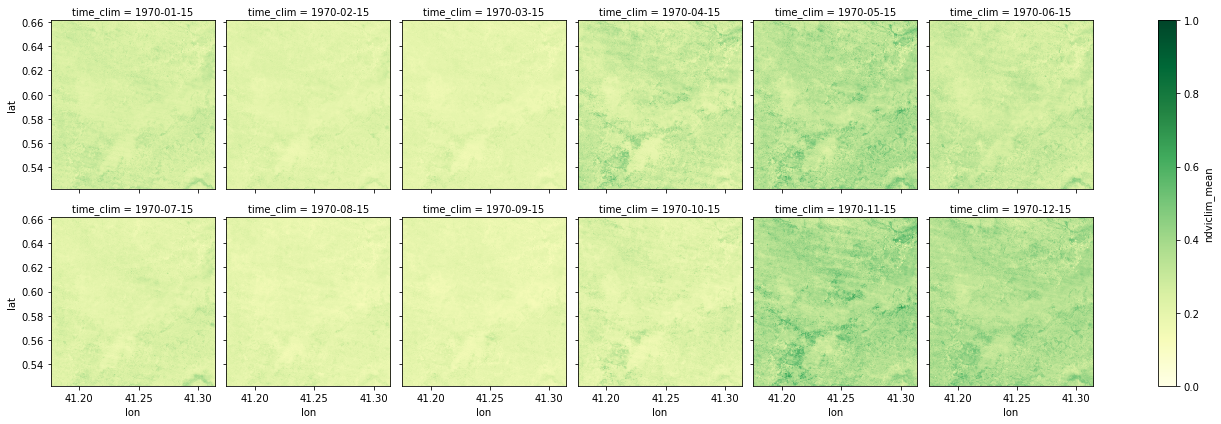

In [10]:
cube.ndviclim_mean.plot.imshow(col = "time_clim", col_wrap = 6, cmap = cmap_veg, vmin = 0, vmax = 1)